# Homework 2  (Due: 10/15/2018)

COEN 281, Fall 2018  
Professor Marwah

---

The objective of this HW is to implement k-NN and cross-validation to find the best value of $k$ for a binary classification task. The task to diagnose breast cancer based on 30 numeric features. However, to keep things simple, we will only use two of those features. The output is binary: 0 benign, 1 malignant. In all there are 569 examples, which we will split into training and test sets. There are no missing values. 

In [1]:
# load the data set
import numpy as np
import pandas as pd
import sklearn.datasets
dat = sklearn.datasets.load_breast_cancer()

In [2]:
print(dat.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [3]:
print(dat.target_names)

['malignant' 'benign']


In [4]:
# uncomment the following and run it to get a description of the data set
print(dat.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [5]:
# dat is a dictionary with the data, let's see what keys it has
dat.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [6]:
print(dat.data.shape)

(569, 30)


In [7]:
df = pd.DataFrame(dat.data, columns=dat.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
# we will use two features: 'mean area' and 'mean concave points'
ix1 = np.where(dat["feature_names"] == "mean area")[0][0]
ix2 = np.where(dat["feature_names"] == "mean concave points")[0][0]
print(ix1)
print(ix2)

3
7


In [9]:
import matplotlib.pyplot as plt
def plot_cells():    
    plt.scatter(dat["data"][:,ix1][dat["target"]==1], dat["data"][:,ix2][dat["target"]==1], marker='x', color='C0')
    plt.scatter(dat["data"][:,ix1][dat["target"]==0], dat["data"][:,ix2][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend(['Benign', 'Malignant'])
plot_cells()

In [10]:
X = dat["data"][:,(ix1,ix2)]
Y = dat["target"]

# verify shape of X and Y
print(X.shape, Y.shape)

# stats of the two features
from scipy import stats
st = stats.describe(X)
print("Number of points: %i" % st.nobs)
print("range (min, max), X1: (%.2f, %.2f), X2: (%.2f, %.2f)" % (st.minmax[0][0], st.minmax[1][0], st.minmax[0][1], st.minmax[1][1]))
print("mean: %.2f, %.2f" % (st.mean[0], st.mean[1]))
print("variance: %.2f, %f" % (st.variance[0], st.variance[1]))
# Given the stats, is it a good idea to normalize the features?
#yes. We have to normalize.For given  features mean area and  mean concave points x=[2501.00,0.20]
#is skewed towards (mean area). so we should normalize.
# add code to normalize features
def normalizeData(X, normalize_cols):
    """ Normalize specified columns of X to range [0,1] in place. """
    min_X = X[:,normalize_cols].min(axis=0)
    max_X = X[:,normalize_cols].max(axis=0)
    X[:,normalize_cols] = (X[:,normalize_cols] - min_X) / (max_X - min_X)
    return min_X, max_X
ranges = normalizeData(X, [True, True])

print(ranges)
st = stats.describe(X)
print("Number of points: %i" % st.nobs)
print("range (min, max), X1: (%.2f, %.2f), X2: (%.2f, %.2f)" % (st.minmax[0][0], st.minmax[1][0], st.minmax[0][1], st.minmax[1][1]))
print("mean: %.2f, %.2f" % (st.mean[0], st.mean[1]))
print("variance: %.2f, %f" % (st.variance[0], st.variance[1]))

(569, 2) (569,)
Number of points: 569
range (min, max), X1: (143.50, 2501.00), X2: (0.00, 0.20)
mean: 654.89, 0.05
variance: 123843.55, 0.001506
(array([143.5,   0. ]), array([2.501e+03, 2.012e-01]))
Number of points: 569
range (min, max), X1: (0.00, 1.00), X2: (0.00, 1.00)
mean: 0.22, 0.24
variance: 0.02, 0.037194


In [11]:
# split into training set / test set
#
# usually you would do the split randomly; here for deterministic results, we assume the data 
# points are already shuffled and take the first 70% as training and the rest as test
#
nTot = X.shape[0]
nTr = int(nTot*0.7)
nTs = nTot - nTr

Xtr = X[0:nTr,]
Ytr = Y[0:nTr]

Xts = X[nTr:nTot,]
Yts = Y[nTr:nTot,]

# verify shapes
print(Xtr.shape, Ytr.shape, Xts.shape, Yts.shape)

(398, 2) (398,) (171, 2) (171,)


In [12]:
Yts.shape

(171,)

## k-NN Implementation

In [13]:
# Implement the following functions for k-NN
# input: Xtr - training examples input features, size nXd
#        Ytr - label (can assume to be binary 0/1), size nX1
#        Xts - test examples input features, for which labels (Yts) 
#              need to be predicted, size mXd
#        k   - k for the k-NN algo 
#
# output: Yts - 0/1 labes for Xts, size mX1
#
#  This function predicts the binary labels for Xts, given the training
#  data Xtr, Ytr and k, using the k-NN algorithm
#
def knn_predict(Xtr, Ytr, Xts, k):
    # compute in two steps
    
    # step 1: compute dist matrix between Xts and Xtr
    #
    dist = compute_dist_mat(Xts, Xtr)
    #dist.shape=171x398
    #print(dist.shape)
    # step 2: use the dist matrix and use k-nn to find labels for Xts 
    # hint: function numpy.argsort may be useful
    # in case of a tie, pick a class randomly
    
    # YOUR CODE HERE
    testShape = dist.shape[0]
    #testShape=171
    #print(testShape)
    yPrediction = np.zeros(testShape)
    for i in range(testShape):
        K_closest_y_5 = []
        #dist[i].shape=398
        #print(dist[i].shape)
        closestIndex_5 = np.argsort(dist[i])[:k]
        #closestIndex_5.shape=5
        #print(closestIndex_5.shape)
        K_closest_y_5 = Ytr[closestIndex_5]
        #print(K_closest_y_5)
        #bincount Count number of occurrences of each value in array
        #print(np.bincount(K_closest_y_5))
        #np.argmax Returns the indices of the maximum values along an axis
        yPrediction[i] = np.argmax(np.bincount(K_closest_y_5))
        #yPrediction.shape=171
    #print(yPrediction)
    return(yPrediction)

#  compute_dist_mat(Xts, Xtr)
#
#  input: Xts - test examples, size mXd
#         Xtr - training examples, size nXd
#  output: L2 distance matrix mXn
#
#   if Xts is mXd, and Xtr is nXd, this function returns a matrix of size mXn with the L2 distances; the (i,j) 
#     entry of the matrix is the L2 distance between ith test and jth training example 
#
def compute_dist_mat(Xts, Xtr):
    # use two for loops to compute the matrix
    # YOUR CODE HERE
    testShape = Xts.shape[0]
    trainShape = Xtr.shape[0]
    dist = np.zeros((testShape, trainShape))
    for i in range(testShape):
        for j in range(trainShape):
            dist[i, j] = np.sqrt(np.sum((Xts[i]-Xtr[j])**2))
    #print(dist.shape)        
    return(dist)

Problem 1 (30 points): Fill-in code for normalizing features, and the above two functions to implement k-NN.

Problem 2 (20 points): Run your k-NN implementation on the test data set. Use k=5. Compute accuracy, recall and precision of the test data set (do not use python library functions to compute these). 

In [14]:
# problem 2 solution:(TP + TN)/float(TP + TN + FP + FN))=156/171
#tp=118,tn=38,fp=1,fn=14
from sklearn import metrics
yprediction=knn_predict(Xtr, Ytr, Xts,k=5)
print(yprediction)
#accuracy=0.9122
#print(metrics.accuracy_score(Yts, yprediction))
test_shape=Xts.shape[0]
correct = np.sum(yprediction == Yts)
accuracy = float(correct)/test_shape
print(correct,test_shape, accuracy)
print("accuracy is %f percenatge"%(accuracy*100))

[1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 1.]
156 171 0.9122807017543859
accuracy is 91.228070 percenatge


In [15]:
TP=np.sum([(yprediction==1) & (1==Yts)])
print(TP)
TN=np.sum([(yprediction==0) & (0==Yts)])
print(TN)
FP=np.sum([(yprediction==1) & (0==Yts)])
print(FP)
FN=np.sum([(yprediction==0) & (1==Yts)])
print(FN)

118
38
1
14


In [16]:
# problem 2 solution-recall=TP/(TP + FN)=118/118+14=0.8939
#print(metrics.recall_score(Yts, yprediction))
print(TP/float(TP + FN))
print("recall is %f percenatge"%((TP/float(TP + FN))*100))

0.8939393939393939
recall is 89.393939 percenatge


In [17]:
# problem 2 solution-precision=TP /(TP + FP)=0.9915
#print(metrics.confusion_matrix(Yts, yprediction))
#print(metrics.precision_score(Yts, yprediction))
print(TP /float(TP + FP))
print("precision is %f percenatge"%((TP /float(TP + FP))*100))

0.9915966386554622
precision is 99.159664 percenatge


## Cross-Validation

Priblem 3 (30 points): Now we will implement 5-fold cross-validation to find the best value of $k$. And then using that value of $k$, re-run k-NN on the test data set. (This is adapted from a past Stanford cs231n assignment)

In [18]:
num_folds = 5
k_choices = [1, 3, 5, 7, 9, 11, 13, 15, 20, 30, 40, 50, 75, 100]

Xtrfolds = []
Ytrfolds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
#np.array_split: Split array into multiple sub-arrays size=num_folds=5.
Xtrfolds = np.array_split(Xtr, num_folds)
Ytrfolds = np.array_split(Ytr, num_folds)
#Ytrfolds.shape=5,
#print(Ytrfolds.shape)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

#create empty list for all k choices
for k in k_choices:
    k_to_accuracies[k] = []


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    for i in range(num_folds):
        #Use fold 1 as the testing set and the union of the other folds as the training set.
        #np.vstack : Stack arrays in sequence vertically (row wise)
        Xtr_cv = np.vstack(Xtrfolds[0:i]+Xtrfolds[i+1:])
        #print(Xtr_cv)
        #np.hstack:Stack arrays in sequence horizontally (column wise).
        Ytr_cv = np.hstack(Ytrfolds[0:i] + Ytrfolds[i+1:])
        
        #test set
        Xts_cv = Xtrfolds[i]
        #print(Xts_cv.shape)
        Yts_cv = Ytrfolds[i]
        #call knn predict 
        yprediction_cv=knn_predict(Xtr_cv, Ytr_cv, Xts_cv,k)
        #yprediction_cv
        
        #accuracy for each CV fold
        correct_cv = np.sum(Yts_cv == yprediction_cv)
        accuracy_cv = (float)(correct_cv)/Yts_cv.shape[0]
        k_to_accuracies[k].append(accuracy_cv)  
        
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))
    print('mean , k=%d is %f' % (k, np.mean(k_to_accuracies[k])))

k = 1, accuracy = 0.787500
k = 1, accuracy = 0.787500
k = 1, accuracy = 0.875000
k = 1, accuracy = 0.873418
k = 1, accuracy = 0.898734
mean , k=1 is 0.844430
k = 3, accuracy = 0.787500
k = 3, accuracy = 0.812500
k = 3, accuracy = 0.887500
k = 3, accuracy = 0.911392
k = 3, accuracy = 0.886076
mean , k=3 is 0.856994
k = 5, accuracy = 0.825000
k = 5, accuracy = 0.837500
k = 5, accuracy = 0.900000
k = 5, accuracy = 0.936709
k = 5, accuracy = 0.911392
mean , k=5 is 0.882120
k = 7, accuracy = 0.837500
k = 7, accuracy = 0.837500
k = 7, accuracy = 0.875000
k = 7, accuracy = 0.949367
k = 7, accuracy = 0.924051
mean , k=7 is 0.884684
k = 9, accuracy = 0.850000
k = 9, accuracy = 0.837500
k = 9, accuracy = 0.900000
k = 9, accuracy = 0.924051
k = 9, accuracy = 0.936709
mean , k=9 is 0.889652
k = 11, accuracy = 0.850000
k = 11, accuracy = 0.825000
k = 11, accuracy = 0.912500
k = 11, accuracy = 0.924051
k = 11, accuracy = 0.936709
mean , k=11 is 0.889652
k = 13, accuracy = 0.887500
k = 13, accuracy =

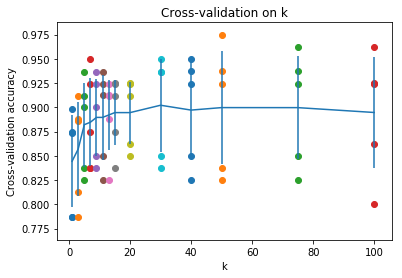

In [19]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [20]:
#k = 30, accuracy = 0.9021(taking average)
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
print(accuracies_mean.max())

0.9021835443037975


Problem 4 (20 points): Based on the cross-validation results above, choose the best value for $k$. Repeat problem 2 with this $k$ (using the entire training data set).

In [21]:
#problem 4 solution-accuracy
#mean for k=5 is 0.882120
#mean for k=15 is 0.894589
#mean for k=30 is 0.902184
#best_value_K=30
yprediction_best_k=knn_predict(Xtr, Ytr, Xts,k=30)

#print(metrics.accuracy_score(Yts, yprediction))
test_shape=Xts.shape[0]
correct = np.sum(yprediction_best_k == Yts)
accuracy = float(correct)/test_shape
print(correct, test_shape, accuracy)

157 171 0.9181286549707602


In [22]:
TP1=np.sum([(yprediction_best_k==1) & (1==Yts)])
print(TP1)
TN1=np.sum([(yprediction_best_k==0) & (0==Yts)])
print(TN1)
FP1=np.sum([(yprediction_best_k==1) & (0==Yts)])
print(FP1)
FN1=np.sum([(yprediction_best_k==0) & (1==Yts)])
print(FN1)

121
36
3
11


In [23]:
# problem 4 solution-recall=TP/(TP + FN)
#print(metrics.recall_score(Yts, yprediction))
print(TP1/float(TP1 + FN1))
print("recall is %f percenatge"%((TP1/float(TP1 + FN1))*100))

0.9166666666666666
recall is 91.666667 percenatge


In [24]:
# problem 4 solution-precision=TP /(TP + FP)
print(TP1 /float(TP1 + FP1))
print("precision is %f percenatge"%((TP1 /float(TP1 + FP1))*100))

0.9758064516129032
precision is 97.580645 percenatge


Note: these extra credit problems are optional and only increase your score marginally. 

Extra Credit Problem 1 (5 points): Plot decision boundaries for the best $k$, similar to how it is done here:
http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

Extra Credit Problem 2 (5 points): In problem 1 above, re-write the compute_dist_mat() function with no loops. That may seem non-intuitive, but it is possible to compute the L2 distances using matrix operations (matrix multiplication, addition, etc.) without explicitly doing the double for loop. The advantage of using matrix operations is that they are highly optimized and enable "vectorization", and for such computations can give 10-100x speed improvements.

In [25]:
#Extra Credit Problem 2
#(a-b)**2=a**2+b**2-2*a*b
def compute_dist_mat_extraCredit(Xts, Xtr):
    XtsSSqr= np.sum(np.square(Xts),axis=1);
    XtrSSqr = np.sum(np.square(Xtr),axis=1);
    mul = np.dot(Xts,Xtr.T);
    distance = np.sqrt(XtsSSqr[:,np.newaxis]+XtrSSqr-2*mul)
    return(distance)